In [355]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# This will automatically reload src/dtree.py every time you make changes and save the file
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [356]:
%matplotlib inline

In [357]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [358]:
df = pd.read_csv('train.csv')

df.head()

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,mileage,omv,arf,opc_scheme,lifespan,eco_category,features,accessories,indicative_price,price
0,1030324,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1 owner! 320i gt m-sports model! big brake kit...,2013.0,NaN,09-dec-2013,luxury sedan,"parf car, premium ad car, low mileage car",...,73000.0,45330.0,50462.0,NaN,NaN,uncategorized,"5 doors gt, powerful and fuel efficient 2.0l t...","bmw i-drive, navigation, bluetooth/aux/usb inp...",NaN,71300.0
1,1021510,Toyota Hiace 3.0M,NaN,hiace,high loan available! low mileage unit. wear an...,2014.0,NaN,26-jan-2015,van,premium ad car,...,110112.0,27502.0,1376.0,NaN,25-jan-2035,uncategorized,low mileage unit. well maintained vehicle. vie...,factory radio setting. front recording camera....,NaN,43800.0
2,1026909,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1 owner c&c unit. full agent service with 1 mo...,2016.0,NaN,25-jul-2016,luxury sedan,"parf car, premium ad car",...,80000.0,27886.0,26041.0,NaN,NaN,uncategorized,responsive and fuel efficient 1.6l inline 4 cy...,dual electric/memory seats. factory fitted aud...,NaN,95500.0
3,1019371,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,"fully agent maintained, 3 years warranty 10 ye...",2019.0,NaN,17-nov-2020,luxury sedan,"parf car, almost new car, consignment car",...,9800.0,46412.0,56977.0,NaN,NaN,uncategorized,"1.5l inline-4 twin scroll turbocharged engine,...",64 colour ambient lighting. active parking ass...,NaN,197900.0
4,1031014,Honda Civic 1.6A VTi,NaN,civic,"kah motor unit! 1 owner, lowest 1.98% for full...",2019.0,NaN,20-sep-2019,mid-sized sedan,parf car,...,40000.0,20072.0,20101.0,NaN,NaN,uncategorized,"1.6l i-vtec engine, 123 bhp, earth dreams cvt ...","s/rims, premium leather seats, factory touch s...",NaN,103200.0


In [359]:
print(df.shape)
print(df.columns.to_list())
print(df.iloc[0])
useless=['listing_id','indicative_price','curb_weight','model','eco_category']
natural_language=['title','description','features','accessories']
single_catagorical={'make':78,'transmission':2,'fuel_type':5,'no_of_owners':7,'type_of_vehicle':0}
multi_catagorical=['category']
numerical=['manufactured','original_reg_date','reg_date','power','engine_cap','mileage','lifespan']
numerical_price=['coe','road_tax','dereg_value','omv','arf']
output=['price']


(16784, 30)
['listing_id', 'title', 'make', 'model', 'description', 'manufactured', 'original_reg_date', 'reg_date', 'type_of_vehicle', 'category', 'transmission', 'curb_weight', 'power', 'fuel_type', 'engine_cap', 'no_of_owners', 'depreciation', 'coe', 'road_tax', 'dereg_value', 'mileage', 'omv', 'arf', 'opc_scheme', 'lifespan', 'eco_category', 'features', 'accessories', 'indicative_price', 'price']
listing_id                                                     1030324
title                           BMW 3 Series 320i Gran Turismo M-Sport
make                                                               bmw
model                                                             320i
description          1 owner! 320i gt m-sports model! big brake kit...
manufactured                                                      2013
original_reg_date                                                  NaN
reg_date                                                   09-dec-2013
type_of_vehicle             

In [360]:
# car brands. to-do: aggregate and convert to ordinal label
make_names = np.unique(df['make'].fillna("NaN"))
print(make_names)

['NaN' 'alfa romeo' 'alpine' 'aston martin' 'audi' 'austin' 'bentley'
 'bmw' 'byd' 'chery' 'chevrolet' 'chrysler' 'citroen' 'cupra' 'daf'
 'daihatsu' 'daimler' 'dodge' 'dongfeng' 'ferrari' 'fiat' 'ford' 'foton'
 'golden dragon' 'hafei' 'higer' 'hino' 'honda' 'hummer' 'hyundai'
 'infiniti' 'international' 'isuzu' 'iveco' 'jaguar' 'jeep' 'joylong'
 'kia' 'lamborghini' 'land rover' 'lexus' 'lotus' 'man' 'maserati' 'maxus'
 'mazda' 'mclaren' 'mercedes' 'mercedes-benz' 'mg' 'mini' 'mitsubishi'
 'mitsuoka' 'morris' 'nissan' 'opel' 'perodua' 'peugeot' 'porsche'
 'proton' 'renault' 'riley' 'rolls-royce' 'rover' 'ruf' 'saab' 'scania'
 'seat' 'skoda' 'ssangyong' 'subaru' 'suzuki' 'tesla' 'toyota' 'ud'
 'volkswagen' 'volvo' 'yutong']


In [361]:
missing_make = np.array(df['make'].isnull())
print(missing_make.sum())

2160


In [362]:
missing_owner = np.array(df['no_of_owners'].isnull())
def extract_owners(d):
    ds = d.split(' ')
    i = -1
    if 'owner' in ds:
        i = ds.index('owner')
    elif 'owners' in ds:
        i = ds.index('owners')
    
    amt = False
    if i != -1:
        amt = ds[i - 1]
    if amt == 'one' or amt == '1' or amt == 'original':
        amt = 1
    elif amt == 'two' or amt == '2':
        amt = 2
    else:
        amt = False
    if amt:
        amt = int(amt)
    return amt

df['description'] = df['description'].str.lower().replace()
owner = np.array(df['description'].map(extract_owners), dtype=bool)
remains = np.logical_and(owner, missing_owner)
df['no_of_owners'][remains] = owner[remains]
print(remains.sum()) # orz...

3


C:\Users\Arthur\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [363]:
# def extract_model(de):
#     model_list = ['alfa romeo', 'alpine', 'aston martin', 'audi', 'austin', 'bentley', 'bmw',
#  'byd', 'chery', 'chevrolet', 'chrysler', 'citroen', 'cupra', 'daf', 'daihatsu',
#  'daimler', 'dodge', 'dongfeng', 'ferrari', 'fiat', 'ford', 'foton',
#  'golden dragon', 'hafei', 'higer', 'hino', 'honda', 'hummer', 'hyundai',
#  'infiniti', 'international', 'isuzu', 'iveco', 'jaguar', 'jeep', 'joylong',
#  'kia', 'lamborghini', 'land rover', 'lexus', 'lotus', 'man', 'maserati', 'maxus',
#  'mazda', 'mclaren', 'mercedes', 'mercedes-benz', 'mg', 'mini', 'mitsubishi',
#  'mitsuoka', 'morris', 'nissan', 'opel', 'perodua', 'peugeot', 'porsche',
#  'proton', 'renault', 'riley', 'rolls-royce', 'rover', 'ruf', 'saab', 'scania',
#  'seat', 'skoda', 'ssangyong', 'subaru', 'suzuki', 'tesla', 'toyota', 'ud',
#  'volkswagen', 'volvo', 'yutong']
#     des = de.split(' ')
#     for d in des:
#         if d in model_list:
#             return d
#     return False

# df['title'] = df['title'].str.lower().replace('-', '')
# make_from_titles = df['title'].map(extract_model)
# b = np.array(make_from_titles, dtype=bool)
# remains = np.logical_and(b, missing_make)
# df['make'][remains] = make_from_titles[remains]
# #2103 make filled

In [364]:
df = df.drop(columns = useless)

In [365]:
d1 = np.array(df['original_reg_date'].isnull())
df['age'] = df['original_reg_date'].copy()
df['age'][d1] = df['reg_date'][d1]
d1 = df['age'].isnull()
df['age'][d1] = df['manufactured'][d1]

def extract_year(date):
    date = str(date)
    if len(date) != 4:
        if '.' in date and len(date) == 6:
            year = date[:-2]
        else:
            l = date.split('-')
            year = l[-1]
    return int(year)
df['age'] = 2021 - df['age'].map(extract_year)

C:\Users\Arthur\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Arthur\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [366]:
# take out outliers
df['age'] = df['age'][df.age < 30]
df['age'] = df['age'][df.age >= 0]

In [367]:
df['fuel_type'] = df['fuel_type'].fillna('petrol')

In [368]:
df.head()

,title,make,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,transmission,power,...,dereg_value,mileage,omv,arf,opc_scheme,lifespan,features,accessories,price,age
0,BMW 3 Series 320i Gran Turismo M-Sport,bmw,1 owner! 320i gt m-sports model! big brake kit...,2013.0,NaN,09-dec-2013,luxury sedan,"parf car, premium ad car, low mileage car",auto,135.0,...,47514.0,73000.0,45330.0,50462.0,NaN,NaN,"5 doors gt, powerful and fuel efficient 2.0l t...","bmw i-drive, navigation, bluetooth/aux/usb inp...",71300.0,8.0
1,Toyota Hiace 3.0M,NaN,high loan available! low mileage unit. wear an...,2014.0,NaN,26-jan-2015,van,premium ad car,manual,NaN,...,3648.0,110112.0,27502.0,1376.0,NaN,25-jan-2035,low mileage unit. well maintained vehicle. vie...,factory radio setting. front recording camera....,43800.0,6.0
2,Mercedes-Benz CLA-Class CLA180,mercedes-benz,1 owner c&c unit. full agent service with 1 mo...,2016.0,NaN,25-jul-2016,luxury sedan,"parf car, premium ad car",auto,90.0,...,44517.0,80000.0,27886.0,26041.0,NaN,NaN,responsive and fuel efficient 1.6l inline 4 cy...,dual electric/memory seats. factory fitted aud...,95500.0,5.0
3,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,"fully agent maintained, 3 years warranty 10 ye...",2019.0,NaN,17-nov-2020,luxury sedan,"parf car, almost new car, consignment car",auto,115.0,...,80301.0,9800.0,46412.0,56977.0,NaN,NaN,"1.5l inline-4 twin scroll turbocharged engine,...",64 colour ambient lighting. active parking ass...,197900.0,1.0
4,Honda Civic 1.6A VTi,NaN,"kah motor unit! 1 owner, lowest 1.98% for full...",2019.0,NaN,20-sep-2019,mid-sized sedan,parf car,auto,92.0,...,36453.0,40000.0,20072.0,20101.0,NaN,NaN,"1.6l i-vtec engine, 123 bhp, earth dreams cvt ...","s/rims, premium leather seats, factory touch s...",103200.0,2.0


In [369]:
df.head()

,title,make,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,transmission,power,...,dereg_value,mileage,omv,arf,opc_scheme,lifespan,features,accessories,price,age
0,BMW 3 Series 320i Gran Turismo M-Sport,bmw,1 owner! 320i gt m-sports model! big brake kit...,2013.0,NaN,09-dec-2013,luxury sedan,"parf car, premium ad car, low mileage car",auto,135.0,...,47514.0,73000.0,45330.0,50462.0,NaN,NaN,"5 doors gt, powerful and fuel efficient 2.0l t...","bmw i-drive, navigation, bluetooth/aux/usb inp...",71300.0,8.0
1,Toyota Hiace 3.0M,NaN,high loan available! low mileage unit. wear an...,2014.0,NaN,26-jan-2015,van,premium ad car,manual,NaN,...,3648.0,110112.0,27502.0,1376.0,NaN,25-jan-2035,low mileage unit. well maintained vehicle. vie...,factory radio setting. front recording camera....,43800.0,6.0
2,Mercedes-Benz CLA-Class CLA180,mercedes-benz,1 owner c&c unit. full agent service with 1 mo...,2016.0,NaN,25-jul-2016,luxury sedan,"parf car, premium ad car",auto,90.0,...,44517.0,80000.0,27886.0,26041.0,NaN,NaN,responsive and fuel efficient 1.6l inline 4 cy...,dual electric/memory seats. factory fitted aud...,95500.0,5.0
3,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,"fully agent maintained, 3 years warranty 10 ye...",2019.0,NaN,17-nov-2020,luxury sedan,"parf car, almost new car, consignment car",auto,115.0,...,80301.0,9800.0,46412.0,56977.0,NaN,NaN,"1.5l inline-4 twin scroll turbocharged engine,...",64 colour ambient lighting. active parking ass...,197900.0,1.0
4,Honda Civic 1.6A VTi,NaN,"kah motor unit! 1 owner, lowest 1.98% for full...",2019.0,NaN,20-sep-2019,mid-sized sedan,parf car,auto,92.0,...,36453.0,40000.0,20072.0,20101.0,NaN,NaN,"1.6l i-vtec engine, 123 bhp, earth dreams cvt ...","s/rims, premium leather seats, factory touch s...",103200.0,2.0


In [370]:
# remove useless atttributes
# deal with missing values
    # convert feature / description and title to fill in missing values for model and make
    # drop original reg date / reg date after using it to fill missing manufactured date, convert to age
    # drop these values afterwards
    # if fuel type is NA, change to petral, which is the default type
# explore remaining attributes
    # standardize, normalize
    # simplify, aggregate
    # one-hot encoding, convert to numerical label
    # remove outliers
# find out other things to clean

# qn: indicative price more representative? combine with retail price?

In [371]:
# new: clean (fill in missing values, remove outliers(single and correlation outliers)) and normalize power, engine cap, mileage

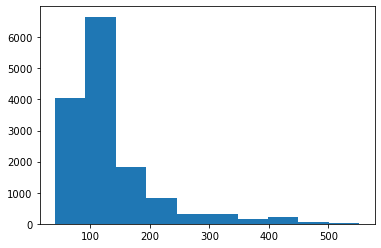

In [372]:
# power
plt.figure()
plt.hist(df["power"].to_numpy())
plt.show()

In [373]:
print(len(df[df.power > 400]))
print(df["power"].isnull().sum())

310
2337


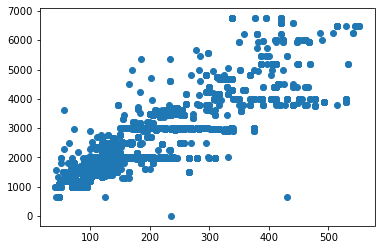

In [374]:
# plot correlation between power and engine cap
plt.scatter(df["power"], df["engine_cap"])
plt.show()

In [375]:
# engine cap
print(df["engine_cap"].isnull().sum())
df = df.dropna(subset = ["engine_cap"]) # only dropping 53

53


In [376]:
# take out outliers acccording to scatter plot
df = df[~((df['power'] > 200) & (df['engine_cap'] < 1000))]

df_valid = df.dropna(subset = ['power'])
powers = df_valid['power'].to_numpy()
caps = df_valid['engine_cap'].to_numpy()

# Find k data points with engine cap most similar to the power of x
# Calculate the median power of those k data points
# Set power of x to the calculated median
# Set k as the number of nearest data points we want to consider
k = 100

# Loop over each data point in our dataset
for idx, row in df.iterrows():
    if idx % 10000 == 0:
        print(idx)

    p, e = row['power'], row['engine_cap']

    diff = np.abs(caps - e)

    indices = np.argsort(diff)[:k]

    k_powers = powers[indices]

    avg = np.average(k_powers)
    
    # Set the weight value of the current row to the median
    df.at[idx, 'power'] = avg

0
10000


In [377]:
df['power_normed'] = (df['power']-df['power'].min()) / (df['power'].max()-df['power'].min())
df['engine_cap_normed'] = (df['engine_cap']-df['engine_cap'].min()) / (df['engine_cap'].max()-df['engine_cap'].min())

In [378]:
# mileage
# missing
# outlier
# normalize
dfvalid = df["mileage"].dropna()
print(dfvalid.mode())
df["mileage"] = df["mileage"].fillna(80000.0)

0    80000.0
dtype: float64


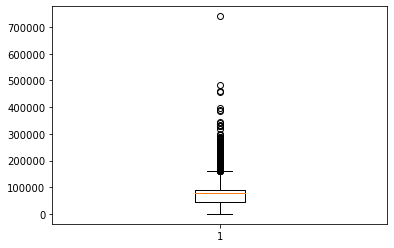

In [379]:
plt.figure()
plt.boxplot(df["mileage"])
plt.show()

In [380]:
df = df[df.mileage < 400000]

In [381]:
df['mileage_normed'] = (df['mileage']-df['mileage'].min()) / (df['mileage'].max()-df['mileage'].min())

In [382]:
# coe: fill in missing value for coe according to: age and power
print(df["arf"].isnull().sum()) #284
print(len(df[df.arf.isnull() & df.dereg_value.isnull()])) #222
df = df[~(df.arf.isnull() & df.dereg_value.isnull())] # remove values whose dereg_value cannot be calculated

281
219


In [383]:
# recalculate reg date: total months
def to_months(x):
    mapper = {}
    all_m = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    for i in range(12):
        mapper[all_m[i]] = i + 1
    if len(str(x)) < 11:
        return int(x)
    s = x.split('-')
    year = 2021 - int(s[-1])
    month = mapper[s[-2]]
    return year * 12 + month

df = df.dropna(subset = ['reg_date'])
df['age_in_month'] = df['reg_date'].map(to_months)

In [384]:
# for date missing both coe and dereg_value, record it's month engine and power
coe_to_search = []
to_search = df[df.coe.isnull() & df.dereg_value.isnull()]

for idx, row in to_search.iterrows():
    # category -> A / B
    power = row["power"]
    engine_cap = row["engine_cap"]
    cat = 2
    month = row["age_in_month"]
    if engine_cap <= 1600 and power <= 97:
        cat = 1
    coe_to_search.append((cat, month))

coe_to_search = list(set(coe_to_search))
print(len(coe_to_search))

70


In [385]:
t_to_coe = {}

for t in coe_to_search:
    t_to_coe[str(t)] = []

remains = df[~df.coe.isnull()]

for idx, row in remains.iterrows():
    if idx % 10000 == 0:
        print(idx)

    power = row["power"]
    engine_cap = row["engine_cap"]
    cat = 2
    month = row["age_in_month"]
    if engine_cap <= 1600 and power <= 97:
        cat = 1
    
    t = (cat, month)
    
    coe = row["coe"]
    if t in coe_to_search:
        t_to_coe[str(t)].append(coe)
        
c = 0
for idx, row in df.iterrows():
    power = row["power"]
    engine_cap = row["engine_cap"]
    cat = 2
    month = row["age_in_month"]
    if engine_cap <= 1600 and power <= 97:
        cat = 1
    t = str((cat, month))

    if type(row["coe"]) == float and pd.isna(row["coe"]):
        l = t_to_coe[t]
        if len(l) > 0:
            avg = sum(l) / len(l)
            df.at[idx, 'coe'] = avg
            c += 1
print(c)

0
10000
837


In [386]:
print(df['coe'].isnull().sum())

34


In [387]:
df = df[~(df.coe.isnull() & df.dereg_value.isnull())]

In [388]:
def clean_tax(x):
    if type(x) != float:
        return None
    return x
df = df.dropna(subset=["road_tax"])
df["road_tax"] = df["road_tax"].map(clean_tax)

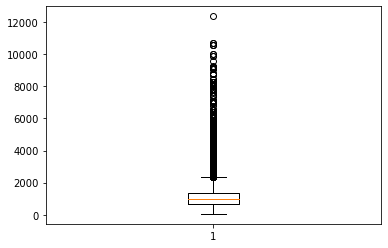

In [389]:
plt.figure()
plt.boxplot(df["road_tax"])
plt.show()

In [390]:
print(df["road_tax"].median())

974.0


In [391]:
import math
for idx, row in df.iterrows():
    rd_tax = row["road_tax"]
    if type(rd_tax) == float and pd.isna(rd_tax):
        rd_tax = 974.0
    if type(row["dereg_value"]) == float and pd.isna(row["dereg_value"]):
        max_age = 10 * 12
        age = row["age_in_month"]
        time_left = max_age - age
        coe = row["coe"]
        omv = row["omv"]
        arf = row["arf"]
        parf_ratio = 0
        if age <  5 * 12:
            parf_ratio = 0.75
        elif age >= 5 * 12 and age < 10 * 12:
            parf_ratio = 0.75 - math.ceil((age - 5 * 12) / 12) * 0.05 
            if parf_ratio < 0.5 or parf_ratio > 0.7:
                print(parf_ratio, age)
                break
        coe_rebate = coe * time_left / 120
        dereg_value = parf_ratio * arf + coe_rebate
        df.at[idx, "remaining_val"] = dereg_value - rd_tax
    else:
        df.at[idx, "remaining_val"] = row["dereg_value"] - rd_tax

In [392]:
df = df.dropna(subset = ['depreciation'])

In [393]:
print(df.columns.to_list())

['title', 'make', 'description', 'manufactured', 'original_reg_date', 'reg_date', 'type_of_vehicle', 'category', 'transmission', 'power', 'fuel_type', 'engine_cap', 'no_of_owners', 'depreciation', 'coe', 'road_tax', 'dereg_value', 'mileage', 'omv', 'arf', 'opc_scheme', 'lifespan', 'features', 'accessories', 'price', 'age', 'power_normed', 'engine_cap_normed', 'mileage_normed', 'age_in_month', 'remaining_val']


In [394]:
df.head()

,title,make,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,transmission,power,...,lifespan,features,accessories,price,age,power_normed,engine_cap_normed,mileage_normed,age_in_month,remaining_val
0,BMW 3 Series 320i Gran Turismo M-Sport,bmw,1 owner! 320i gt m-sports model! big brake kit...,2013.0,NaN,09-dec-2013,luxury sedan,"parf car, premium ad car, low mileage car",auto,145.580,...,NaN,"5 doors gt, powerful and fuel efficient 2.0l t...","bmw i-drive, navigation, bluetooth/aux/usb inp...",71300.0,8.0,0.228344,0.089796,0.184005,108,46304.0
2,Mercedes-Benz CLA-Class CLA180,mercedes-benz,1 owner c&c unit. full agent service with 1 mo...,2016.0,NaN,25-jul-2016,luxury sedan,"parf car, premium ad car",auto,100.720,...,NaN,responsive and fuel efficient 1.6l inline 4 cy...,dual electric/memory seats. factory fitted aud...,95500.0,5.0,0.112985,0.063057,0.201650,67,43777.0
3,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,"fully agent maintained, 3 years warranty 10 ye...",2019.0,NaN,17-nov-2020,luxury sedan,"parf car, almost new car, consignment car",auto,92.360,...,NaN,"1.5l inline-4 twin scroll turbocharged engine,...",64 colour ambient lighting. active parking ass...,197900.0,1.0,0.091487,0.056539,0.024700,23,79617.0
4,Honda Civic 1.6A VTi,NaN,"kah motor unit! 1 owner, lowest 1.98% for full...",2019.0,NaN,20-sep-2019,mid-sized sedan,parf car,auto,101.483,...,NaN,"1.6l i-vtec engine, 123 bhp, earth dreams cvt ...","s/rims, premium leather seats, factory touch s...",103200.0,2.0,0.114948,0.063190,0.100824,33,35711.0
6,Volvo V40 T2,volvo,beautiful exterior and interior. straight chas...,2015.0,NaN,11-dec-2015,hatchback,"parf car, premium ad car",auto,98.330,...,NaN,"1.5l inline 4 cylinder turbocharged engine, fr...","multi-function steering wheel, original audio ...",62500.0,6.0,0.106840,0.056605,0.196047,84,36627.0


In [395]:
# process single-catagorical data

def to_cat(x,value_list):
    c = value_list.index(x)
    return c


for h in single_catagorical:
    print(h)
    df[h]=df[h].fillna('none')
    value_list=list(set(df[h].values))
    if "none" in value_list:
        print("Has NaN Value.")
        value_list.remove("none")
        value_list.sort()
        value_list=["none"]+value_list
    print(value_list)
    single_catagorical[h]=len(value_list)
    df[h] = df[h].apply(to_cat,args=(value_list,))
    #print(df[h].value_counts())

make
Has NaN Value.
['none', 'alfa romeo', 'alpine', 'aston martin', 'audi', 'austin', 'bentley', 'bmw', 'chery', 'chevrolet', 'chrysler', 'citroen', 'cupra', 'daihatsu', 'daimler', 'dodge', 'ferrari', 'fiat', 'ford', 'honda', 'hummer', 'hyundai', 'infiniti', 'jaguar', 'jeep', 'kia', 'lamborghini', 'land rover', 'lexus', 'lotus', 'maserati', 'maxus', 'mazda', 'mclaren', 'mercedes', 'mercedes-benz', 'mg', 'mini', 'mitsubishi', 'mitsuoka', 'nissan', 'opel', 'perodua', 'peugeot', 'porsche', 'proton', 'renault', 'rolls-royce', 'rover', 'ruf', 'saab', 'seat', 'skoda', 'ssangyong', 'subaru', 'suzuki', 'toyota', 'volkswagen', 'volvo']
transmission
['auto', 'manual']
fuel_type
['diesel', 'petrol-electric', 'petrol']
no_of_owners
Has NaN Value.
['none', 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
type_of_vehicle
['bus/mini bus', 'stationwagon', 'luxury sedan', 'others', 'sports car', 'suv', 'hatchback', 'mid-sized sedan', 'mpv']


In [396]:
#process multi-catagorical data
def to_multi_cat(x,value_list):
    c=[]
    for i,value in enumerate(value_list):
        if value in x:
            c.append(i)
    return c


for h in multi_catagorical:
    print(h)
    data=list(df[h].fillna('none').unique())
    #print(data)
    catagory=set([])
    for l in data:
        cat_l=l.strip('-').split(",")
        for cat in cat_l:
            if len(cat)!=0:
                catagory.add(cat.strip(" "))
    value_list=list(catagory)
    value_list.sort()
    print(value_list)
    df[h]=df[h].apply(to_multi_cat,args=(value_list,))

category
['almost new car', 'coe car', 'consignment car', 'direct owner sale', 'hybrid cars', 'imported used vehicle', 'low mileage car', 'opc car', 'parf car', 'premium ad car', 'rare & exotic', 'sgcarmart warranty cars', 'sta evaluated car', 'vintage cars']


In [397]:
df.head()

,title,make,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,transmission,power,...,lifespan,features,accessories,price,age,power_normed,engine_cap_normed,mileage_normed,age_in_month,remaining_val
0,BMW 3 Series 320i Gran Turismo M-Sport,7,1 owner! 320i gt m-sports model! big brake kit...,2013.0,NaN,09-dec-2013,2,"[6, 8, 9]",0,145.580,...,NaN,"5 doors gt, powerful and fuel efficient 2.0l t...","bmw i-drive, navigation, bluetooth/aux/usb inp...",71300.0,8.0,0.228344,0.089796,0.184005,108,46304.0
2,Mercedes-Benz CLA-Class CLA180,35,1 owner c&c unit. full agent service with 1 mo...,2016.0,NaN,25-jul-2016,2,"[8, 9]",0,100.720,...,NaN,responsive and fuel efficient 1.6l inline 4 cy...,dual electric/memory seats. factory fitted aud...,95500.0,5.0,0.112985,0.063057,0.201650,67,43777.0
3,Mercedes-Benz E-Class E180 Avantgarde,35,"fully agent maintained, 3 years warranty 10 ye...",2019.0,NaN,17-nov-2020,2,"[0, 2, 8]",0,92.360,...,NaN,"1.5l inline-4 twin scroll turbocharged engine,...",64 colour ambient lighting. active parking ass...,197900.0,1.0,0.091487,0.056539,0.024700,23,79617.0
4,Honda Civic 1.6A VTi,0,"kah motor unit! 1 owner, lowest 1.98% for full...",2019.0,NaN,20-sep-2019,7,[8],0,101.483,...,NaN,"1.6l i-vtec engine, 123 bhp, earth dreams cvt ...","s/rims, premium leather seats, factory touch s...",103200.0,2.0,0.114948,0.063190,0.100824,33,35711.0
6,Volvo V40 T2,58,beautiful exterior and interior. straight chas...,2015.0,NaN,11-dec-2015,6,"[8, 9]",0,98.330,...,NaN,"1.5l inline 4 cylinder turbocharged engine, fr...","multi-function steering wheel, original audio ...",62500.0,6.0,0.106840,0.056605,0.196047,84,36627.0
